## This is my attempt at implementing the RouBl algorithm

In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

In [ ]:
class FullCovGaussianNetwork(nn.Module):
    """Applies a linear transformation to the incoming data: y = xW^T + b, where
    the weight W and bias b are sampled from the q distribution.
    """

    def __init__(self, layer_sizes, prior_param_std=1.0, init_std=0.05,
                 sqrt_width_scaling=False, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()
        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]

        # calculate the number of parameters
        self.num_params = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))

        # define the trainable variational parameters for q distribtuion
        # first define and initialise the mean parameters
        self.mean = nn.Parameter(torch.zeros(self.num_params, **factory_kwargs))

        self._cov_diag = nn.Parameter(torch.zeros(self.num_params, **factory_kwargs))
        self._cov_tril = nn.Parameter(torch.zeros((self.num_params, self.num_params), **factory_kwargs))
        
        # self.reset_parameters(init_std)

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_param_std /= self.dim_in ** 0.5
            
        self.prior_param_std = prior_param_std

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', torch.full((self.num_params,), prior_mean, **factory_kwargs))
        prior_std_diag = torch.full_like(self.mean, prior_param_std)
        self.register_buffer('prior_scale_tril', prior_std_diag.diag_embed())


    # I don't know what this is doing
    # def reset_parameters(self, init_std=0.5):
    #     nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
    #     bound = self.dim_in ** -0.5
    #     nn.init.uniform_(self.bias_mean, -bound, bound)
    #     _init_std_param = math.log(math.expm1(init_std))
    #     self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
    #     self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator#
   
    @property
    def scale_tril(self):
        # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
        # Only taking values below the main diagonal? no it takes everything below diagonal
        return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)


    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.scale_tril)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_scale_tril)
        kl = dist.kl_divergence(q, p).sum()
        return kl


    def sample_params(self):
        sample = self.mean + self.scale_tril @ torch.randn_like(self.mean)
        return sample


    # def compute_gradients(self, K=100):
    #     for k in range():
    #         sample = sample_params(self)

        

    # forward pass with Monte Carlo (MC) sampling
    def forward(self, input):
        flat_params = self.sample_params()
        start = 0 
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = flat_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = flat_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)  # Or another activation if desired
        return input


# # construct a BNN
net = FullCovGaussianNetwork([1, 2, 1], prior_param_std=0.05)
q = dist.MultivariateNormal(net.mean, scale_tril=net.scale_tril)



Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

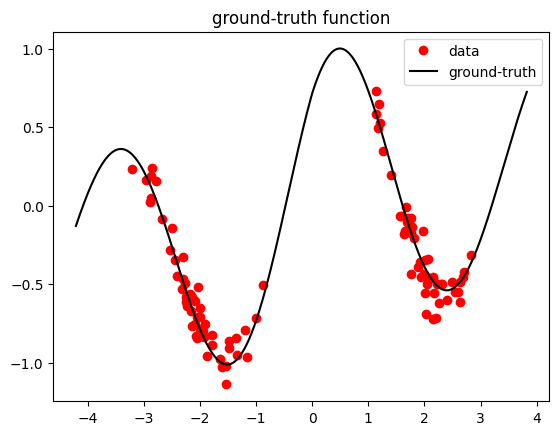

In [2]:
def ground_truth_func(x):
    return np.sin(x * math.pi / 2 + 0.8) * np.exp(-0.1 * np.abs(x)) + 0.1 * x

def gen_data(N_data, ground_truth_func, noise_std=None):
    # generate the training dataset, note here we will make data into 2 clusters
    x1 = np.random.randn(int(N_data/2), 1) * 0.5 + 2.0
    x2 = np.random.randn(int(N_data/2), 1) * 0.5 - 2.0
    x = np.concatenate([x1, x2], axis=0)
    y = ground_truth_func(x)
    if noise_std is not None and noise_std > EPS:
        # assume homogeneous noise setting, i.e., "homoscedasticity"
        y += np.random.randn(y.shape[0], y.shape[1]) * noise_std
    return x, y

def normalise_data(x, mean, std):
    return (x - mean) / std

def unnormalise_data(x, mean, std):
    return x * std + mean

class regression_data(Dataset):
     def __init__(self, x, y, normalise=True):
         super(regression_data, self).__init__()
         self.update_data(x, y, normalise)

     def __len__(self):
         return self.x.shape[0]

     def __getitem__(self, index):
         x = torch.tensor(self.x[index]).float()
         y = torch.tensor(self.y[index]).float()
         return x, y

     def update_data(self, x, y, normalise=True, update_stats=True):
         assert x.shape[0] == y.shape[0]
         self.x = x
         self.y = y
         # normalise data
         self.normalise = normalise
         if update_stats:
             self.x_mean = self.x.mean(0) if normalise else 0.0
             self.x_std = self.x.std(0) if normalise else 1.0
             self.y_mean = self.y.mean(0) if normalise else 0.0
             self.y_std = self.y.std(0) if normalise else 1.0
         if self.normalise:
             self.x = normalise_data(self.x, self.x_mean, self.x_std)
             self.y = normalise_data(self.y, self.y_mean, self.y_std)

N_data = 100
noise_std = 0.1
x_train, y_train = gen_data(N_data, ground_truth_func, noise_std)
dataset = regression_data(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# plot the training data and ground truth
x_test = np.arange(np.min(x_train) - 1.0, np.max(x_train)+1.0, 0.01)[:, np.newaxis]
y_test = ground_truth_func(x_test)
plt.plot(x_train, y_train, 'ro', label='data')
plt.plot(x_test, y_test, 'k-', label='ground-truth')
plt.legend()
plt.title('ground-truth function')
plt.show()

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
x_dim, y_dim = x_train.shape[1], y_train.shape[1]
# build a BNN, with hidden layer width = h_dim
h_dim = 50
layer_sizes = [x_dim, h_dim, h_dim, y_dim]
# you can change the activation function here or define your own customized activation
# activation=nn.GELU()
activation = nn.LeakyReLU(negative_slope=0.01)
# you can change the prior parameters as you wish
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'init_std': 0.05,
                'device': device}

full_regression_net = make_full_bnn(layer_sizes, activation=activation, **layer_kwargs) ## I commented this in



# we assume a Gaussian likelihood with homogeneuous noise
log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# print out the BNN settings
print("BNN architecture: \n", full_regression_net) ## and trhi

NameError: name 'make_full_bnn' is not defined

In [31]:
# collect the kl divergence for all MFVILinear layers
def kl_divergence(bnn):
    kl = 0.0
    for module in bnn:
        if hasattr(module, 'kl_divergence'):
            kl = kl + module.kl_divergence()
    return kl

# define the training function which minimises the negative ELBO
# note that the (tempered) negative ELBO = negative log-likliehood of dataset + beta * KL
# where the neg. log-likelihood *per datapoint* is computed with a function
# nll = data_loss_func(y, y_pred)
# this data_loss_func is to be defined later, depending on the learning task
def train_step(net, opt, data_loss_func, dataloader, N_data, beta=1.0):
    for _, (x, y) in enumerate(dataloader):
        x = x.to(device); y = y.to(device)
        opt.zero_grad() # opt is the optimiser
        y_pred = net(x)
        ### begin of your code ###
        # notice we might use mini-batches, so be careful for the right data-count!

        nll = data_loss_func(y, y_pred).mean()
        kl = kl_divergence(net)
        loss = N_data * nll + beta * kl
    

        ### end of your code ###

        loss.backward()
        opt.step()
    return nll, kl

# now define the data_loss_func that will be used later
# in detail, we will define a Gaussian log-likelihood function below, and then define
# data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
# where log_noise_var is the output noise (log) variance which is a seperate model parameter
# define gaussian log-likelihood
def gauss_loglik(y, y_pred, log_noise_var):
    # y should have shape as (batch_size, y_dim)
    # y_pred should have shape as (batch_size, y_dim) or (K, batch_size, y_dim)
    # where K is the number of MC samples
    # this function should return per-data loss of shape (batch_size,) or (K, batch_size)
    ### begin of your code ###
    # hint: consult with your textbook or wikipedia for the Gaussian distribution form
    l2_dist = (y-y_pred).pow(2).sum(-1)
    ll = -0.5 * (log_noise_var + math.log(2*math.pi) + l2_dist * torch.exp(-log_noise_var))

    ### end of your code ###
    return ll

# define the prediction function with Monte Carlo sampling using K samples
def predict(bnn, x_test, K=1):
    y_pred = []
    for _ in range(K):
        y_pred.append(bnn(x_test))
    # shape (K, batch_size, y_dim) or (batch_size, y_dim) if K = 1
    return torch.stack(y_pred, dim=0).squeeze(0)

# define the error metrics: RMSE and test negative log-likelihood
# in below functions y_pred should have shape (K, batch_size, y_dim) or (batch_size, y_dim)
def rmse(y, y_pred):
    if len(y_pred.shape) > 2: # using K > 1 MC samples
        y_pred = y_pred.mean(0)
    return (y - y_pred).pow(2).sum(-1).mean().sqrt()

def test_nll(y, y_pred, data_loss_func):
    nll = data_loss_func(y, y_pred)  # with shape (batch_size) or (K, batch_size)
    if len(nll) == 2:  # using K > 1 MC samples
        nll = -torch.logsumexp(-nll, dim=0) + math.log(nll.shape[0]) # Bayesian predictive average
    return nll.mean()

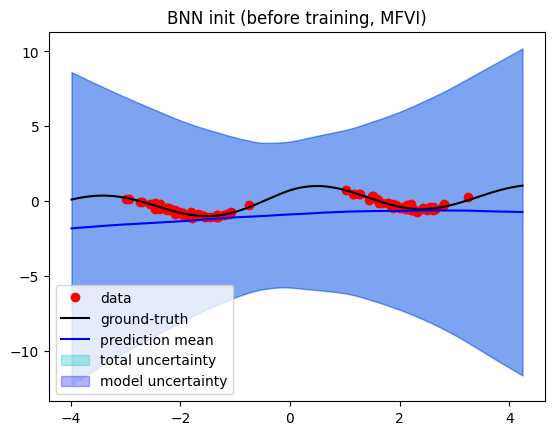

[0.09394694] 0.1 3.551146553906856


In [32]:

# plot the BNN prior in function space
K = 50  # number of Monte Carlos samples used in test time
x_test_norm = normalise_data(x_test, dataset.x_mean, dataset.x_std)
x_test_norm = torch.tensor(x_test_norm, ).float().to(device)

def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

def get_regression_results(net, x, K, log_noise_var=None):
    y_pred = predict(net, x, K=K)  # shape (K, N_test, y_dim)
    y_pred_mean = y_pred.mean(0)
    if log_noise_var is not None:
        # note here the preditive std needs to count for output noise variance
        y_pred_std = (y_pred.var(0) + torch.exp(log_noise_var)).sqrt()
    else:
        y_pred_std = y_pred.std(0)
    # unnormalise
    y_pred_mean = unnormalise_data(to_numpy(y_pred_mean), dataset.y_mean, dataset.y_std)
    y_pred_std = unnormalise_data(to_numpy(y_pred_std), 0.0, dataset.y_std)
    return y_pred_mean, y_pred_std

# plot the BNN prior and ground truth
def plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std, title=''):
    plt.plot(x_train, y_train, 'ro', label='data')
    plt.plot(x_test, y_test, 'k-', label='ground-truth')
    plt.plot(x_test, y_pred_mean, 'b-', label='prediction mean')
    # plot the uncertainty as +- 2 * std
    # first for the total uncertainty (model/epistemic + data/aleatoric)
    plt.fill_between(x_test[:,0], y_pred_mean[:,0]-2*y_pred_std[:,0],
                     y_pred_mean[:,0]+2*y_pred_std[:,0],
                     color='c', alpha=0.3, label='total uncertainty')
    # then for the model/epistemic uncertainty only
    plt.fill_between(x_test[:,0], y_pred_mean[:,0]-2*y_pred_std_noiseless[:,0],
                     y_pred_mean[:,0]+2*y_pred_std_noiseless[:,0],
                     color='b', alpha=0.3, label='model uncertainty')
    plt.legend()
    plt.title(title)
    plt.show()

y_pred_mean, y_pred_std_noiseless = get_regression_results(full_regression_net, x_test_norm, K) ## and this
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*log_noise_var)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN init (before training, MFVI)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

### Training

In [ ]:
# define the training function
def train_network(net, opt, dataloader, data_loss_func, learning_rate=1e-3,
                  N_epochs=2000, beta=1.0, verbose=True):
    net.train()
    logs = []
    for i in range(N_epochs):
        nll, kl = train_step(net, opt, data_loss_func, dataloader,
                          N_data=len(dataloader.dataset), beta=beta)
        logs.append([to_numpy(nll), to_numpy(kl)])
        if (i+1) % 100 == 0 and verbose:
            print("Epoch {}, nll={}, kl={}".format(i+1, logs[-1][0], logs[-1][1]))
    return np.array(logs)

# start training
learning_rate = 1e-3
params = list(mfvi_regression_net.parameters()) + [log_noise_var]
opt = torch.optim.Adam(params, lr=learning_rate)
# define the regression loss: negative gaussian log-likelihood
data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
# hyper-parameters of training
beta = 1.0
N_epochs = 2000
# the training loop starts
logs = train_network(mfvi_regression_net, opt, dataloader, data_loss_func,
                     beta=beta, verbose=True, N_epochs=N_epochs)

# plot the training curve
def plot_training_loss(logs, beta):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(np.arange(logs.shape[0]), logs[:, 0], 'r-', label='nll')
    ax2.plot(np.arange(logs.shape[0]), logs[:, 1], 'r-', label='KL')
    ax1.legend()
    ax2.legend()
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_title('ELBO (beta={})'.format(beta))
    ax2.set_title('ELBO (beta={})'.format(beta))
    plt.show()

plot_training_loss(logs, beta)